<a href="https://colab.research.google.com/github/Ilia-Gershen/TYP-project/blob/main/DeepLearningModelGRU_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Model GRU-LSTM:

In [ ]:
#importing libraries and data from google drive
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

#for Normalization
from sklearn import preprocessing

from google.colab import drive #connecting google drive with Database of the project
drive.mount('/content/drive')

# Importing the csv made in data preprocessing stage
ETH = pd.read_csv("/content/drive/MyDrive/Database/ETH-preprocessed.csv")
ETH.head()
print(type(ETH))

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>


## Functions used in all models

In [ ]:
def DrawingTrainAndValLoss(historyDict): #Function helps to draw the validation and training loss of models, as well as rmsr of training and validation

  loss = historyDict["loss"]
  root_mean_squared_error = historyDict["root_mean_squared_error"]
  valLoss = historyDict["val_loss"]
  val_root_mean_squared_error = historyDict["val_root_mean_squared_error"]

  epochs = range(1, len(loss) + 1)

  fig, (ax1, ax2) = plt.subplots(1, 2)

  fig.set_figheight(5)
  fig.set_figwidth(15)

  ax1.plot(epochs, loss, label = 'Training Loss')
  ax1.plot(epochs, valLoss, label = 'Validation Loss')
  ax1.set(xlabel = "Epochs", ylabel = "Loss")
  ax1.legend()

  ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
  ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
  ax2.set(xlabel = "Epochs", ylabel = "Loss")
  ax2.legend()

  plt.show()

In [ ]:
def CalculateErrors(ETH_Test_Y, ETH_prediction): #Function calculates the evaluation metrics for the models and prints them

  mse = mean_squared_error(ETH_Test_Y.reshape(-1,7), ETH_prediction)
  print(f'MSE: {mse}')

  mae = mean_absolute_error(ETH_Test_Y.reshape(-1,7), ETH_prediction)
  print(f'MAE: {mae}')

  rmse = math.sqrt(mean_squared_error(ETH_Test_Y.reshape(-1,7), ETH_prediction))
  print(f'RMSE: {rmse}')

  mape = np.mean(np.abs(ETH_Test_Y.reshape(-1,7) - ETH_prediction )/np.abs(ETH_Test_Y.reshape(-1,7))) * 100
  print(f'MAPE: {mape}')

## GRU-LSTM 1
With closing price as input and 1 week prediction window

### Data processing
Splitting data into training, validation and testing sets

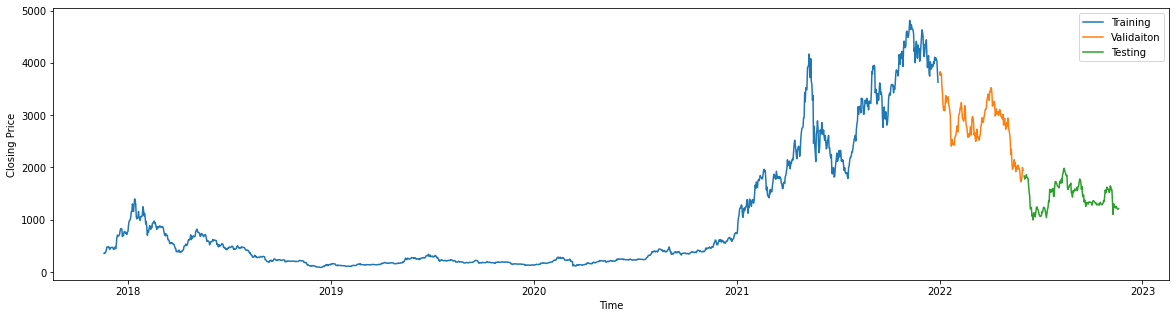

In [ ]:
def Dataset(Data):

  #Swap date into right format
  Data["Date"] = pd.to_datetime(Data["Date"])

  #Data for Training
  #From 2018 to 2022
  Train_Data = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy() #taking data befor the given date
  TrainingData = []
  TrainingDataX = []
  TrainingDataY = []

  for i in range(0, len(Train_Data), 7): #putting in close values data in form of weeks aka 7 days
    try:
      TrainingData.append(Train_Data[i : i+7]) #array of arrays of 7 close prices
    except:
      pass

  if len(TrainingData[-1]) < 7: #If last week is less then 7 days we remove last week
    TrainingData.pop(-1)

  TrainingDataX = TrainingData[0 : -1] # taking all but last element
  TrainingDataX = np.array(TrainingDataX)
  TrainingDataX = TrainingDataX.reshape((-1, 7, 1)) #split into groups of 7


  TrainingDataY = TrainingData[1:len(TrainingData)] # Taking all but first element
  TrainingDataY = np.array(TrainingDataY)
  TrainingDataY = TrainingDataY.reshape((-1, 7, 1)) # split into groups of 7 and keep the order

  #Data for Validation
  #From 2022 to 2022-06
  Val_Data = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date
  ValData = []
  ValDataX = []
  ValDataY = []

  for i in range(0, len(Val_Data), 7):
    try:
      ValData.append(Val_Data[i : i + 7])
    except:
      pass

  if len(ValData[-1]) < 7:
    ValData.pop(-1)

  ValDataX = ValData[0 : -1]
  ValDataX = np.array(ValDataX)
  ValDataX = ValDataX.reshape((-1, 7, 1))

  ValDataY = ValData[1 : len(ValData)]
  ValDataY = np.array(ValDataY)
  ValDataY = ValDataY.reshape((-1, 7, 1))

  #Data for Testing
  #From 2022-06 to the end

  Test_Data = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()
  TestData = []
  TestDataX = []
  TestDataY = []

  for i in range(0, len(Test_Data), 7):
    try:
      TestData.append(Test_Data[i : i+7])
    except:
      pass

  if len(TestData[-1]) < 7:
    TestData.pop(-1)

  TestDataX = TestData[0 : -1]
  TestDataX = np.array(TestDataX)
  TestDataX = TestDataX.reshape((-1, 7, 1))

  TestDataY = TestData[1 : len(TestData)]
  TestDataY = np.array(TestDataY)
  TestDataY = TestDataY.reshape((-1, 7, 1))

  return TrainingDataX, TrainingDataY, ValDataX, ValDataY, TestDataX, TestDataY

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH)

#graph printing to show the data split
plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validaiton')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

###Model

In [ ]:
def Model():

  model = tf.keras.models.Sequential([ #input shape first number is number of days we will predict and second one is number of purumenters use for prediction
      tf.keras.layers.GRU(200, input_shape = (7,1), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

model = Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7, 200)            121800    
                                                                 
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 7)                 357       
                                                                 
Total params: 468,107
Trainable params: 468,107
Non-trainable params: 0
_________________________________________________________________


### Learning Rate

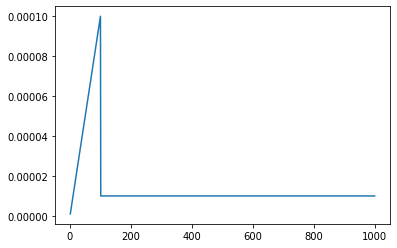

In [ ]:
def scheduler(epoch):
  if epoch <= 100:
    lrate = epoch * (10 ** -6)
  else:
    lrate = 0.00001

  return lrate

epoch = [i for i in range(1, 1001)]
lrate = [scheduler(i) for i in range(1, 1001)]
plt.plot(epoch, lrate)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler) #applying new learning rate to callback that is used as input for model compilation

### Model Fitting

Epoch 1/200
7/7 [==============================] - 3s 96ms/step - loss: 2135410.7500 - root_mean_squared_error: 1461.3044 - val_loss: 7726353.0000 - val_root_mean_squared_error: 2779.6318 - lr: 0.0000e+00
Epoch 2/200
7/7 [==============================] - 0s 39ms/step - loss: 2134573.2500 - root_mean_squared_error: 1461.0179 - val_loss: 7722325.5000 - val_root_mean_squared_error: 2778.9072 - lr: 1.0000e-06
Epoch 3/200
7/7 [==============================] - 0s 36ms/step - loss: 2132289.2500 - root_mean_squared_error: 1460.2360 - val_loss: 7713945.0000 - val_root_mean_squared_error: 2777.3987 - lr: 2.0000e-06
Epoch 4/200
7/7 [==============================] - 0s 37ms/step - loss: 2129710.7500 - root_mean_squared_error: 1459.3529 - val_loss: 7703529.5000 - val_root_mean_squared_error: 2775.5232 - lr: 3.0000e-06
Epoch 5/200
7/7 [==============================] - 0s 38ms/step - loss: 2126166.5000 - root_mean_squared_error: 1458.1379 - val_loss: 7687957.0000 - val_root_mean_squared_error: 27

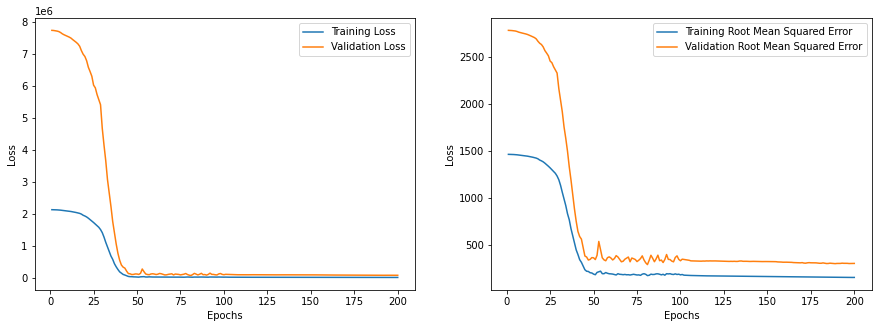

In [ ]:
ETH_Model = Model()
ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH_hist.history)

### Model Testing

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

# Prediction closeup
plt.figure(figsize = (10, 5))

plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

CalculateErrors(ETH_Test_Y, ETH_prediction)

NameError: ignored

## GRU-LSTM 2
With closing price normalized and 1 week prediction window

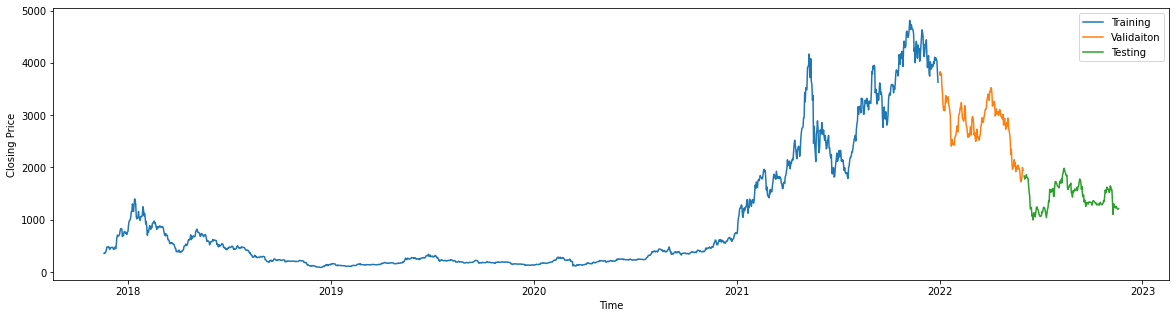

In [ ]:
def Dataset(Data, input): #function for creation of traning and testing datasets for the models

  Data["Date"] = pd.to_datetime(Data["Date"])

  #Data for Training
  #From 2018 to 2022
  #Train_DataY = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy() #taking data befor the given date
  TrainingData = []
  TrainingDataX = []
  TrainingDataY = []

  #0+
  Train_Data = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy()

  #1502+
  Train_Data_Val = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy()

  #1652+
  Train_Data_Test = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()

  Train_Data = np.append(Train_Data,  Train_Data_Val)
  Train_Data = np.append(Train_Data,  Train_Data_Test)

  if input == 1:
    #Normalize by scaling to a range
    minn = min(Train_Data)
    maxx = max(Train_Data)
    for i in range(len(Train_Data)):
      new = (Train_Data[i]-minn)/(maxx-minn)
      Train_Data[i] = new

  elif input == 2:
    #Normalize by log scaling
    for i in range(len(Train_Data)):
      Train_Data[i] = math.log(Train_Data[i])

  else:
    #Normalize by Z-score
    sum = 0
    for i in Train_Data:
        sum += i
    mean = sum/len(Train_Data)
    standardDev = np.std(Train_Data)
    for i in range(len(Train_Data)):
      Train_Data[i] = (Train_Data[i] - mean)/standardDev

  Train_DataY = Train_Data[7:]
  Train_DataY = Train_DataY.reshape(1, -1)

  Train_Data = Train_Data.reshape(1, -1)

  #The training output of the model in TrainingDataY
  #for i in range(0, len(Train_DataY), 7): #putting in close values data in form of weeks aka 7 days
   # try:
  #    TrainingData.append(Train_DataY[i : i+7]) #array of arrays of 7 close prices
  #  except:
  #    pass

  #if len(TrainingData[-1]) < 7: #If last week is less then 7 days we remove last week
  #  TrainingData.pop(-1)

  #TrainingDataY = TrainingData[1:len(TrainingData)] # Taking all but first element
  #TrainingDataY = np.array(TrainingDataY)
  #TrainingDataY = TrainingDataY.reshape((-1, 7, 1)) #split into groups of 7

  #The training input for the model in TrainingDataX
  TrainingDataXWV = np.zeros((213, 7, 1))

  counter = 0
  for i in range(213):
    for l in range(7):
      TrainingDataXWV[i,l,0] = Train_Data[0,counter]
      counter += 1

  TrainingDataX = TrainingDataXWV

  TrainDataYWV = np.zeros((213, 7, 1))
  counter = 0
  for i in range(213):
    for l in range(7):
      TrainDataYWV[i,l,0] = Train_DataY[0, counter]
      counter += 1
  TrainingDataY = TrainDataYWV

  #Data for Validation
  #From 2022 to 2022-06
  Val_Data = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date
  ValData = []
  ValDataX = []
  ValDataY = []

  #Volume_Data = Data['Volume'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date

  #for i in range(0, len(Val_Data), 7): #putting in close values data in form of weeks aka 7 days
   # try:
   #   ValData.append(Val_Data[i : i+7]) #array of arrays of 7 close prices
  #  except:
   #   pass

 # if len(ValData[-1]) < 7: #If last week is less then 7 days we remove last week
  #  ValData.pop(-1)

 ## ValDataY = ValData[1 : len(ValData)]
 # ValDataY = np.array(ValDataY)
 # ValDataY = ValDataY.reshape((-1, 7, 1))

  #The training input for the model in TrainingDataX
  ValDataXWV = np.zeros((20, 7, 1))

  counter = 0
  for i in range(20):
    for l in range(7):
      ValDataXWV[i,l,0] = Train_Data[0,1502+counter]
      counter += 1

  ValDataX = ValDataXWV

  ValDataYWV = np.zeros((20, 7, 1))
  counter = 0
  for i in range(20):
    for l in range(7):
      ValDataYWV[i,l,0] = Train_DataY[0,1502+counter]
      counter += 1
  ValDataY = ValDataYWV

  #Data for Testing
  #From 2022-06 to the end

  Test_Data = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()
  TestData = []
  TestDataX = []
  TestDataY = []

  #Volume_Data = Data['Volume'][Data['Date'] >= '2022-06-02'].to_numpy()

  #for i in range(0, len(Test_Data), 7): #putting in close values data in form of weeks aka 7 days
  #  try:
   #   TestData.append(Test_Data[i : i+7]) #array of arrays of 7 close prices
   # except:
   #   pass

 # if len(TestData[-1]) < 7: #If last week is less then 7 days we remove last week
  #  TestData.pop(-1)

  #TestDataY = TestData[1 : len(TestData)]
  #TestDataY = np.array(TestDataY)
 # TestDataY = TestDataY.reshape((-1, 7, 1))

  #The training input for the model in TrainingDataX
  TestDataXWV = np.zeros((23, 7, 1))

  counter = 0
  for i in range(23):
    for l in range(7):
      #TrainingDataX[i, l].append(Volume_Data[counter])
      TestDataXWV[i,l,0] = Train_Data[0,1653+counter]
      counter += 1

  TestDataX = TestDataXWV

  TestDataYWV = np.zeros((23, 7, 1))
  counter = 0
  for i in range(23):
    for l in range(7):
      TestDataYWV[i,l,0] = Train_DataY[0,1653+counter]
      counter += 1
  TestDataY = TestDataYWV

  return TrainingDataX, TrainingDataY, ValDataX, ValDataY, TestDataX, TestDataY

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, 1)

#The graph shows how data is devided into Training Validation and Testing
plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validaiton')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [ ]:
def Model():
#The input shape is going to be 14 total 7 close and 7 volume
  model = tf.keras.models.Sequential([ #input shape first number is number of days we will predict and second one is number of purumenters use for prediction
      tf.keras.layers.GRU(200, input_shape = (7,1), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

### Normalization by scaling to a range

In [ ]:
def scheduler(epoch):
  if epoch <= 125:
    lrate = 0.00015
  else:
    lrate = 0.00009

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Epoch 1/200
7/7 [==============================] - 4s 116ms/step - loss: 0.0905 - root_mean_squared_error: 0.3009 - val_loss: 0.3222 - val_root_mean_squared_error: 0.5676 - lr: 1.5000e-04
Epoch 2/200
7/7 [==============================] - 0s 43ms/step - loss: 0.0865 - root_mean_squared_error: 0.2941 - val_loss: 0.3065 - val_root_mean_squared_error: 0.5536 - lr: 1.5000e-04
Epoch 3/200
7/7 [==============================] - 0s 42ms/step - loss: 0.0819 - root_mean_squared_error: 0.2861 - val_loss: 0.2844 - val_root_mean_squared_error: 0.5333 - lr: 1.5000e-04
Epoch 4/200
7/7 [==============================] - 0s 44ms/step - loss: 0.0744 - root_mean_squared_error: 0.2728 - val_loss: 0.2506 - val_root_mean_squared_error: 0.5006 - lr: 1.5000e-04
Epoch 5/200
7/7 [==============================] - 0s 43ms/step - loss: 0.0644 - root_mean_squared_error: 0.2537 - val_loss: 0.2062 - val_root_mean_squared_error: 0.4541 - lr: 1.5000e-04
Epoch 6/200
7/7 [==============================] - 0s 46ms/step 

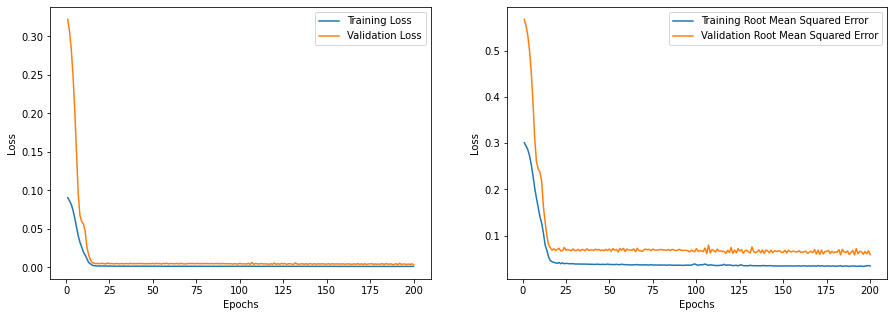

In [ ]:
ETH_Model = Model()
ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH_hist.history)

1/1 [==============================] - 0s 473ms/step
MSE: 0.001727172787863298
MAE: 0.029755755629442472
RMSE: 0.04155926837497621
MAPE: 10.97242699380105


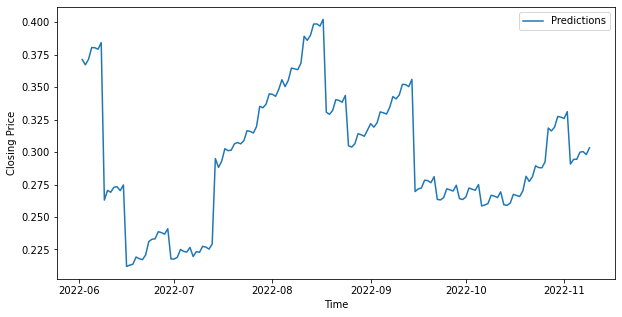

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

plt.figure(figsize = (10, 5))

#plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
#error calculations
CalculateErrors(ETH_Test_Y, ETH_prediction)

### Normalization by log scaling

Epoch 1/200
7/7 [==============================] - 5s 151ms/step - loss: 38.5209 - root_mean_squared_error: 6.2065 - val_loss: 60.7167 - val_root_mean_squared_error: 7.7921 - lr: 1.5000e-04
Epoch 2/200
7/7 [==============================] - 0s 49ms/step - loss: 37.0727 - root_mean_squared_error: 6.0887 - val_loss: 57.7411 - val_root_mean_squared_error: 7.5988 - lr: 1.5000e-04
Epoch 3/200
7/7 [==============================] - 0s 42ms/step - loss: 34.9254 - root_mean_squared_error: 5.9098 - val_loss: 52.9096 - val_root_mean_squared_error: 7.2739 - lr: 1.5000e-04
Epoch 4/200
7/7 [==============================] - 0s 43ms/step - loss: 31.3872 - root_mean_squared_error: 5.6024 - val_loss: 43.8820 - val_root_mean_squared_error: 6.6244 - lr: 1.5000e-04
Epoch 5/200
7/7 [==============================] - 0s 44ms/step - loss: 24.6957 - root_mean_squared_error: 4.9695 - val_loss: 27.1368 - val_root_mean_squared_error: 5.2093 - lr: 1.5000e-04
Epoch 6/200
7/7 [==============================] - 0s 

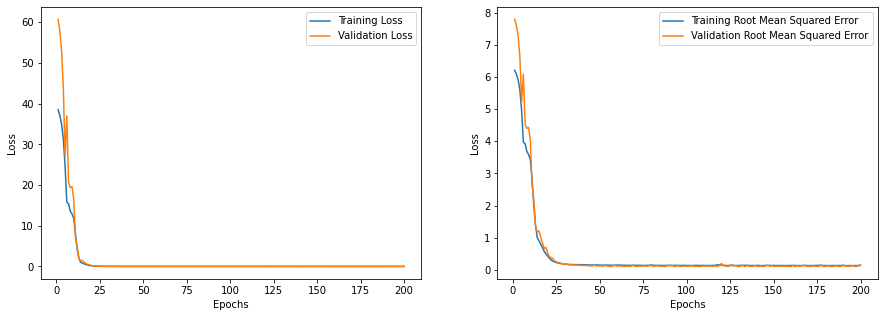

In [ ]:
ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, 2)

def scheduler(epoch):
  if epoch <= 125: #125
    lrate = 0.00015 #0.00015
  else:
    lrate = 0.00009

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

ETH_Model = Model()
ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH_hist.history)

1/1 [==============================] - 0s 343ms/step
MSE: 0.025276050850021426
MAE: 0.11747607550282758
RMSE: 0.1589844358735201
MAPE: 1.6328801646131879


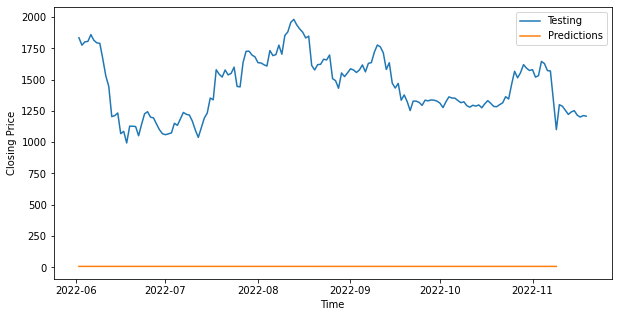

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

plt.figure(figsize = (10, 5))

plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
#error calculations
CalculateErrors(ETH_Test_Y, ETH_prediction)

### Normalization by Z-score

Epoch 1/200
7/7 [==============================] - 5s 172ms/step - loss: 0.9682 - root_mean_squared_error: 0.9840 - val_loss: 1.9713 - val_root_mean_squared_error: 1.4040 - lr: 1.5000e-04
Epoch 2/200
7/7 [==============================] - 1s 77ms/step - loss: 0.9481 - root_mean_squared_error: 0.9737 - val_loss: 1.8951 - val_root_mean_squared_error: 1.3766 - lr: 1.5000e-04
Epoch 3/200
7/7 [==============================] - 1s 79ms/step - loss: 0.9226 - root_mean_squared_error: 0.9605 - val_loss: 1.7829 - val_root_mean_squared_error: 1.3352 - lr: 1.5000e-04
Epoch 4/200
7/7 [==============================] - 1s 76ms/step - loss: 0.8842 - root_mean_squared_error: 0.9403 - val_loss: 1.6166 - val_root_mean_squared_error: 1.2715 - lr: 1.5000e-04
Epoch 5/200
7/7 [==============================] - 0s 44ms/step - loss: 0.8220 - root_mean_squared_error: 0.9066 - val_loss: 1.3626 - val_root_mean_squared_error: 1.1673 - lr: 1.5000e-04
Epoch 6/200
7/7 [==============================] - 0s 43ms/step 

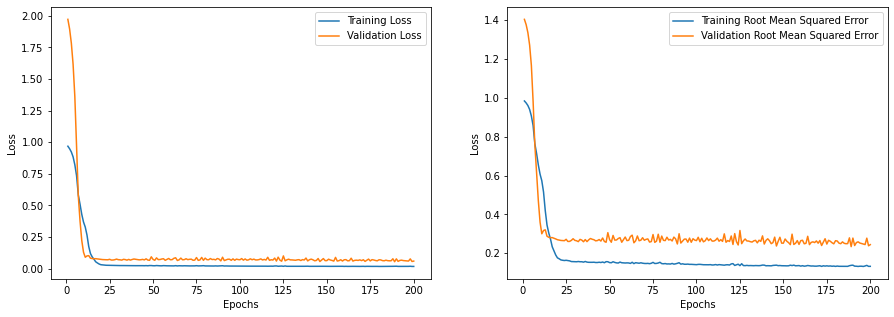

In [ ]:
ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, 3)

def scheduler(epoch):
  if epoch <= 125:
    lrate = 0.00015
  else:
    lrate = 0.00009

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

ETH_Model = Model()
ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH_hist.history)

1/1 [==============================] - 0s 312ms/step
MSE: 0.03713280991882011
MAE: 0.1419823109424585
RMSE: 0.19269875432607267
MAPE: 527.8365737836024


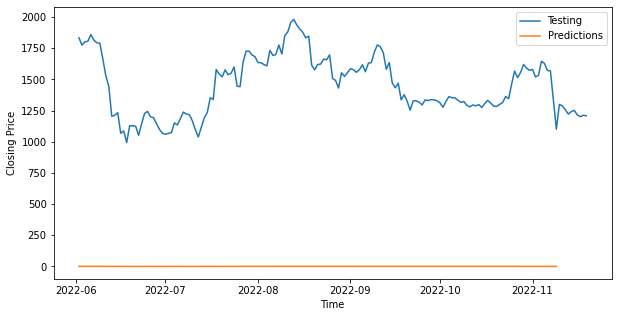

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

plt.figure(figsize = (10, 5))

plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
#error calculations
CalculateErrors(ETH_Test_Y, ETH_prediction)

## GRU-LSTM 3
With closing price and volume of trading (both normalized), 1 week prediction window

### Data processing
Splitting data into training, validation and testing sets

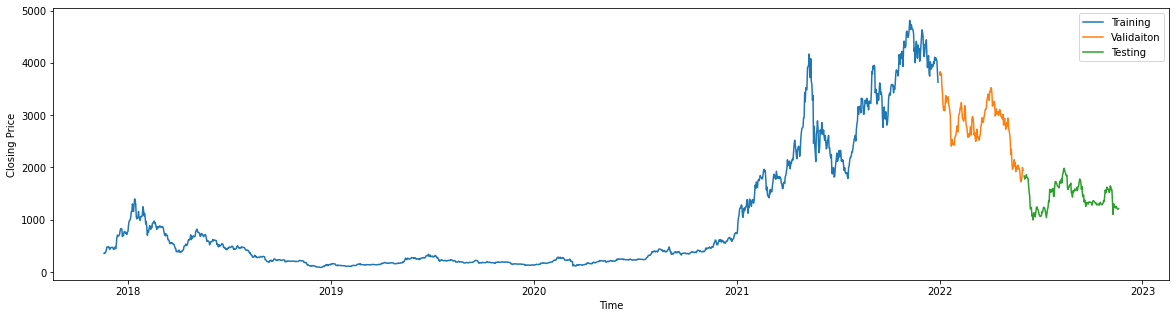

In [ ]:
def Dataset(Data, input): #function for creation of traning and testing datasets for the models

  Data["Date"] = pd.to_datetime(Data["Date"])

  #Data for Training
  #From 2018 to 2022
  #Train_DataY = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy() #taking data befor the given date
  TrainingData = []
  TrainingDataX = []
  TrainingDataY = []

  #0+
  Train_Data = Data['Close'][Data['Date'] < '2021-12-30'].to_numpy()

  #1502+
  Train_Data_Val = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy()

  #1652+
  Train_Data_Test = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()

  Train_Data = np.append(Train_Data,  Train_Data_Val)
  Train_Data = np.append(Train_Data,  Train_Data_Test)

  #Normalize
  if input == 1:
    #Normalize by scaling to a range
    minn = min(Train_Data)
    maxx = max(Train_Data)
    for i in range(len(Train_Data)):
      new = (Train_Data[i]-minn)/(maxx-minn)
      Train_Data[i] = new

  elif input == 2:
    #Normalize by log scaling
    for i in range(len(Train_Data)):
      Train_Data[i] = math.log(Train_Data[i])

  else:
    #Normalize by Z-score
    sum = 0
    for i in Train_Data:
      sum += i
    mean = sum/len(Train_Data)
    standardDev = np.std(Train_Data)
    for i in range(len(Train_Data)):
      Train_Data[i] = (Train_Data[i] - mean)/standardDev

  Train_DataY = Train_Data[7:]
  Train_DataY = Train_DataY.reshape(1, -1)

  Train_Data = Train_Data.reshape(1, -1)

  #0+
  Volume_Data = Data['Volume'][Data['Date'] < '2021-12-30'].to_numpy()

  #1502+
  Volume_Data_Val = Data['Volume'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy()

  #1652+
  Volume_Data_Test = Data['Volume'][Data['Date'] >= '2022-06-02'].to_numpy()

  Volume_Data = np.append(Volume_Data,  Volume_Data_Val)
  Volume_Data = np.append(Volume_Data,  Volume_Data_Test)

  if input == 1:
    #Normalize by scaling to a range
    minn = min(Volume_Data)
    maxx = max(Volume_Data)
    for i in range(len(Volume_Data)):
      new = (Volume_Data[i]-minn)/(maxx-minn)
      Volume_Data[i] = new

  elif input == 2:
    #Normalize by log scaling
    for i in range(len(Volume_Data)):
      Volume_Data[i] = math.log(Volume_Data[i])

  else:
    #Normalize by Z-score
    sum = 0
    for i in Volume_Data:
      sum += i
    mean = sum/len(Volume_Data)
    standardDev = np.std(Volume_Data)
    for i in range(len(Volume_Data)):
      Volume_Data[i] = (Volume_Data[i] - mean)/standardDev

  Volume_Data = Volume_Data.reshape(1, -1)

  #The training output of the model in TrainingDataY
  #for i in range(0, len(Train_DataY), 7): #putting in close values data in form of weeks aka 7 days
  #  try:
   #   TrainingData.append(Train_DataY[i : i+7]) #array of arrays of 7 close prices
   # except:
   #   pass

  #if len(TrainingData[-1]) < 7: #If last week is less then 7 days we remove last week
  #  TrainingData.pop(-1)

 # TrainingDataY = TrainingData[1:len(TrainingData)] # Taking all but first element
 # TrainingDataY = np.array(TrainingDataY)
 # TrainingDataY = TrainingDataY.reshape((-1, 7, 1)) #split into groups of 7

  #The training input for the model in TrainingDataX
  TrainingDataXWV = np.zeros((213, 7, 2))

  counter = 0
  for i in range(213):
    for l in range(7):
      TrainingDataXWV[i,l,0] = Train_Data[0,counter]
      TrainingDataXWV[i,l,1] = Volume_Data[0,counter]
      counter += 1

  TrainingDataX = TrainingDataXWV

  TrainDataYWV = np.zeros((213, 7, 1))
  counter = 0
  for i in range(213):
    for l in range(7):
      TrainDataYWV[i,l,0] = Train_DataY[0,counter]
      counter += 1
  TrainingDataY = TrainDataYWV

  #Data for Validation
  #From 2022 to 2022-06
  Val_Data = Data['Close'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date
  ValData = []
  ValDataX = []
  ValDataY = []

  #Volume_Data = Data['Volume'][(Data['Date'] >= '2022-01-01') & (Data['Date'] < '2022-06-01')].to_numpy() #taking data from given date to latest date

  #for i in range(0, len(Val_Data), 7): #putting in close values data in form of weeks aka 7 days
  #  try:
   #   ValData.append(Val_Data[i : i+7]) #array of arrays of 7 close prices
  #  except:
   #   pass

 # if len(ValData[-1]) < 7: #If last week is less then 7 days we remove last week
 #   ValData.pop(-1)

 # ValDataY = ValData[1 : len(ValData)]
 # ValDataY = np.array(ValDataY)
 # ValDataY = ValDataY.reshape((-1, 7, 1))

  #The training input for the model in TrainingDataX
  ValDataXWV = np.zeros((20, 7, 2))

  counter = 0
  for i in range(20):
    for l in range(7):
      ValDataXWV[i,l,0] = Train_Data[0,1502+counter]
      ValDataXWV[i,l,1] = Volume_Data[0,1502+counter]
      counter += 1

  ValDataX = ValDataXWV

  ValDataYWV = np.zeros((20, 7, 1))
  counter = 0
  for i in range(20):
    for l in range(7):
      ValDataYWV[i,l,0] = Train_DataY[0,1502+counter]
      counter += 1
  ValDataY = ValDataYWV

  #Data for Testing
  #From 2022-06 to the end

  Test_Data = Data['Close'][Data['Date'] >= '2022-06-02'].to_numpy()
  TestData = []
  TestDataX = []
  TestDataY = []

  #Volume_Data = Data['Volume'][Data['Date'] >= '2022-06-02'].to_numpy()

  #for i in range(0, len(Test_Data), 7): #putting in close values data in form of weeks aka 7 days
   # try:
   #   TestData.append(Test_Data[i : i+7]) #array of arrays of 7 close prices
   # except:
   #   pass

 # if len(TestData[-1]) < 7: #If last week is less then 7 days we remove last week
  #  TestData.pop(-1)

 # TestDataY = TestData[1 : len(TestData)]
 # TestDataY = np.array(TestDataY)
 # TestDataY = TestDataY.reshape((-1, 7, 1))

  #The training input for the model in TrainingDataX
  TestDataXWV = np.zeros((23, 7, 2))

  counter = 0
  for i in range(23):
    for l in range(7):
      #TrainingDataX[i, l].append(Volume_Data[counter])
      TestDataXWV[i,l,0] = Train_Data[0,1653+counter]
      TestDataXWV[i,l,1] = Volume_Data[0,1653+counter]
      counter += 1

  TestDataX = TestDataXWV

  TestDataYWV = np.zeros((23, 7, 1))
  counter = 0
  for i in range(23):
    for l in range(7):
      TestDataYWV[i,l,0] = Train_DataY[0,1653+counter]
      counter += 1
  TestDataY = TestDataYWV

  return TrainingDataX, TrainingDataY, ValDataX, ValDataY, TestDataX, TestDataY

ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, 1)
#The graph shows how data is devided into Training Validation and Testing
plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-12-30'], ETH['Close'][ETH['Date'] < '2021-12-30'], label = 'Training')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], ETH['Close'][(ETH['Date'] >= '2022-01-01') & (ETH['Date'] < '2022-06-01')], label = 'Validaiton')
plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

### Model

In [ ]:
def Model():
#The input shape is going to be 14 total 7 close and 7 volume
  model = tf.keras.models.Sequential([ #input shape first number is number of days we will predict and second one is number of purumenters use for prediction
      tf.keras.layers.GRU(200, input_shape = (7,2), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

model = Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7, 200)            122400    
                                                                 
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 7)                 357       
                                                                 
Total params: 468,707
Trainable params: 468,707
Non-trainable params: 0
_________________________________________________________________


### Normalization by scaling to range

#### Learning Rate

In [ ]:
def scheduler(epoch):
  if epoch <= 125:
    lrate = 0.00015
  else:
    lrate = 0.00009

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#### Model Fitting

Epoch 1/200
7/7 [==============================] - 7s 185ms/step - loss: 0.0908 - root_mean_squared_error: 0.3013 - val_loss: 0.3243 - val_root_mean_squared_error: 0.5694 - lr: 1.5000e-04
Epoch 2/200
7/7 [==============================] - 0s 48ms/step - loss: 0.0870 - root_mean_squared_error: 0.2949 - val_loss: 0.3072 - val_root_mean_squared_error: 0.5543 - lr: 1.5000e-04
Epoch 3/200
7/7 [==============================] - 0s 49ms/step - loss: 0.0815 - root_mean_squared_error: 0.2855 - val_loss: 0.2855 - val_root_mean_squared_error: 0.5344 - lr: 1.5000e-04
Epoch 4/200
7/7 [==============================] - 0s 52ms/step - loss: 0.0748 - root_mean_squared_error: 0.2736 - val_loss: 0.2532 - val_root_mean_squared_error: 0.5032 - lr: 1.5000e-04
Epoch 5/200
7/7 [==============================] - 0s 47ms/step - loss: 0.0652 - root_mean_squared_error: 0.2554 - val_loss: 0.2060 - val_root_mean_squared_error: 0.4538 - lr: 1.5000e-04
Epoch 6/200
7/7 [==============================] - 0s 53ms/step 

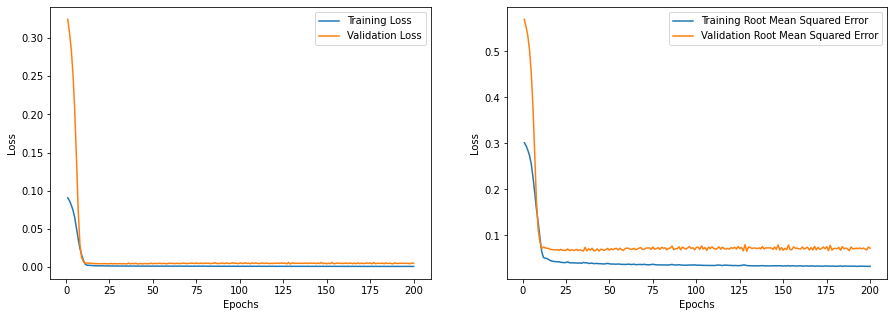

In [ ]:
ETH_Model = Model()
ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])
#plotting
DrawingTrainAndValLoss(ETH_hist.history)

#### Model Testing

1/1 [==============================] - 0s 499ms/step
MSE: 0.0029472809029826657
MAE: 0.04060978783349447
RMSE: 0.05428886536834847
MAPE: 15.342056748672894


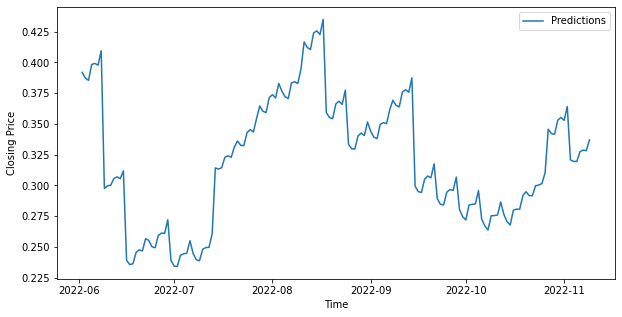

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

#plotting prediction
plt.figure(figsize = (10, 5))

#plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
#error calculations
CalculateErrors(ETH_Test_Y, ETH_prediction)

### Normalization by log scaling

Epoch 1/200
7/7 [==============================] - 5s 125ms/step - loss: 35.1706 - root_mean_squared_error: 5.9305 - val_loss: 52.1194 - val_root_mean_squared_error: 7.2194 - lr: 1.5000e-04
Epoch 2/200
7/7 [==============================] - 0s 49ms/step - loss: 27.8712 - root_mean_squared_error: 5.2793 - val_loss: 37.3373 - val_root_mean_squared_error: 6.1104 - lr: 1.5000e-04
Epoch 3/200
7/7 [==============================] - 0s 48ms/step - loss: 15.5828 - root_mean_squared_error: 3.9475 - val_loss: 14.2695 - val_root_mean_squared_error: 3.7775 - lr: 1.5000e-04
Epoch 4/200
7/7 [==============================] - 0s 54ms/step - loss: 5.8447 - root_mean_squared_error: 2.4176 - val_loss: 1.5704 - val_root_mean_squared_error: 1.2532 - lr: 1.5000e-04
Epoch 5/200
7/7 [==============================] - 0s 54ms/step - loss: 1.3979 - root_mean_squared_error: 1.1823 - val_loss: 3.1168 - val_root_mean_squared_error: 1.7654 - lr: 1.5000e-04
Epoch 6/200
7/7 [==============================] - 0s 68ms

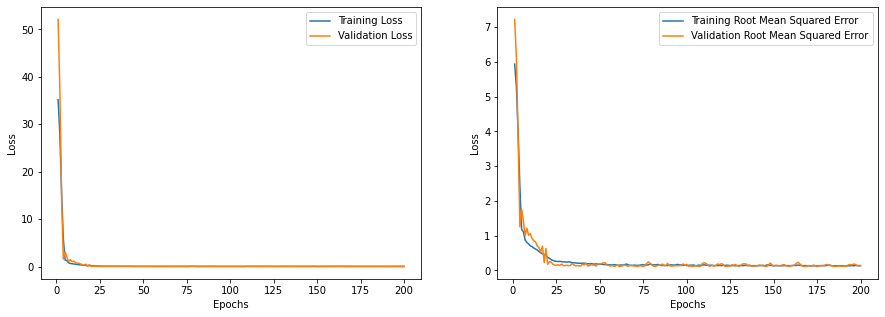

In [ ]:
ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, 2)

def scheduler(epoch):
  if epoch <= 125:
    lrate = 0.00015
  else:
    lrate = 0.00009

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

ETH_Model = Model()
ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH_hist.history)

1/1 [==============================] - 0s 390ms/step
MSE: 0.022896688462164992
MAE: 0.10703943370273927
RMSE: 0.151316517479636
MAPE: 1.487353256030158


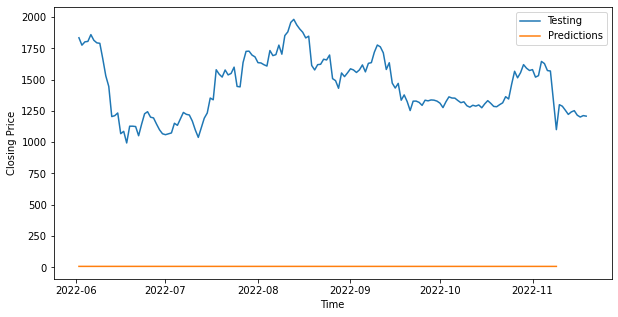

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

plt.figure(figsize = (10, 5))

plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
#error calculations
CalculateErrors(ETH_Test_Y, ETH_prediction)

### Normalization by Z-score

Epoch 1/200
7/7 [==============================] - 7s 146ms/step - loss: 0.9601 - root_mean_squared_error: 0.9798 - val_loss: 1.9577 - val_root_mean_squared_error: 1.3992 - lr: 1.5000e-04
Epoch 2/200
7/7 [==============================] - 0s 47ms/step - loss: 0.9347 - root_mean_squared_error: 0.9668 - val_loss: 1.8696 - val_root_mean_squared_error: 1.3673 - lr: 1.5000e-04
Epoch 3/200
7/7 [==============================] - 0s 49ms/step - loss: 0.8993 - root_mean_squared_error: 0.9483 - val_loss: 1.7582 - val_root_mean_squared_error: 1.3260 - lr: 1.5000e-04
Epoch 4/200
7/7 [==============================] - 0s 48ms/step - loss: 0.8546 - root_mean_squared_error: 0.9244 - val_loss: 1.5977 - val_root_mean_squared_error: 1.2640 - lr: 1.5000e-04
Epoch 5/200
7/7 [==============================] - 0s 52ms/step - loss: 0.7915 - root_mean_squared_error: 0.8897 - val_loss: 1.3815 - val_root_mean_squared_error: 1.1754 - lr: 1.5000e-04
Epoch 6/200
7/7 [==============================] - 0s 45ms/step 

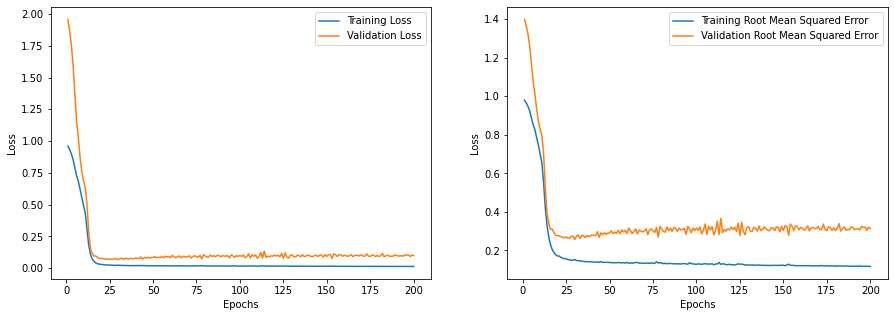

In [ ]:
ETH_Train_X, ETH_Train_Y, ETH_Val_X, ETH_Val_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, 3)

def scheduler(epoch):
  if epoch <= 125:
    lrate = 0.00015
  else:
    lrate = 0.00009

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

ETH_Model = Model()
ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())
ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Val_X, ETH_Val_Y), callbacks = [callback])

DrawingTrainAndValLoss(ETH_hist.history)

1/1 [==============================] - 0s 459ms/step
MSE: 0.04457807796928538
MAE: 0.14933368824598164
RMSE: 0.21113521252809864
MAPE: 675.3568514351743


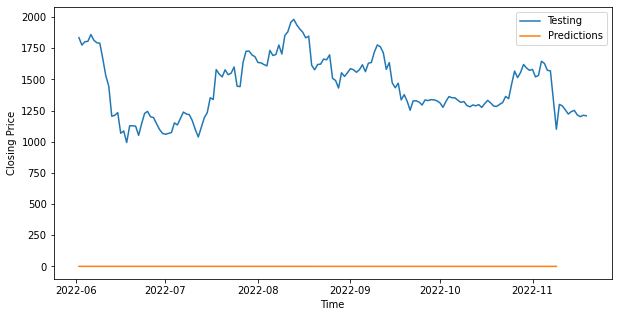

In [ ]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

plt.figure(figsize = (10, 5))

plt.plot(ETH['Date'][ETH['Date'] >= '2022-06-02'], ETH['Close'][ETH['Date'] >= '2022-06-02'], label = 'Testing')
plt.plot(ETH['Date'][(ETH['Date'] >= '2022-06-02')&(ETH['Date'] <= '2022-11-09')], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
#error calculations
CalculateErrors(ETH_Test_Y, ETH_prediction)